In [34]:
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

In [35]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
# %config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [36]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

img = torchvision.io.read_image("dog.jpg")
print(img.shape)

dog.jpg exists
torch.Size([3, 1365, 2048])


In [37]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img


MinMaxScaler()

In [38]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape


(3, 1365, 2048)

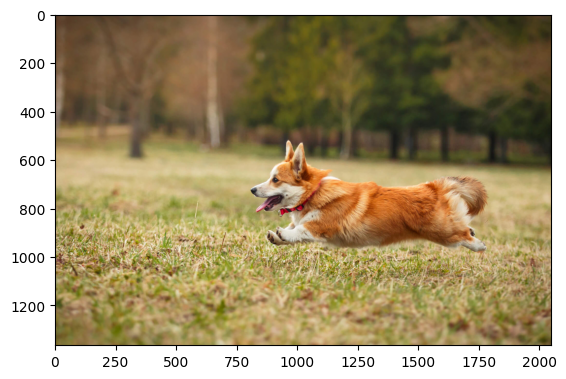

In [39]:
img_scaled = torch.tensor(img_scaled)

crop = img_scaled.to(device)
# crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)

plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())


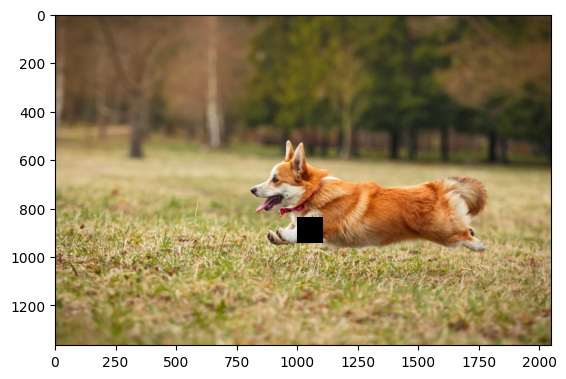

In [40]:

top_left_x = 1000
top_left_y = 840
square_size = 100
crop[:, top_left_y:top_left_y + square_size, top_left_x:top_left_x + square_size] = np.nan

plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [41]:
def factorize(A, r, device=torch.device("cpu")):
    """Factorize the matrix A into W and H
    A: input matrix of size (n_users, n_movies)
    k: number of latent features

    Returns W and H
    W: matrix of size (n_users, k)
    H: matrix of size (k, n_movies)
    """
    A = A.to(device)
    # Randomly initialize W and H
    W = torch.randn(A.shape[0], r, requires_grad=True, device=device)
    H = torch.randn(r, A.shape[1], requires_grad=True, device=device)

    # Optimizer
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    # Train the model
    for i in range(1000):
        # Compute the loss
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
                # Zero the gradients
        optimizer.zero_grad()

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()
    return W, H, loss


In [42]:

crop = torch.tensor(crop, dtype=torch.float)
crop = crop.mean(dim=0, keepdim=False)
crop.shape

torch.Size([1365, 2048])

In [43]:
# Mask the image with NaN values
def mask_image(img, prop):
    img_copy = img.clone().cpu()
    mask = torch.rand(img.shape) < prop
    img_copy[mask] = float('nan')
    return img_copy, mask

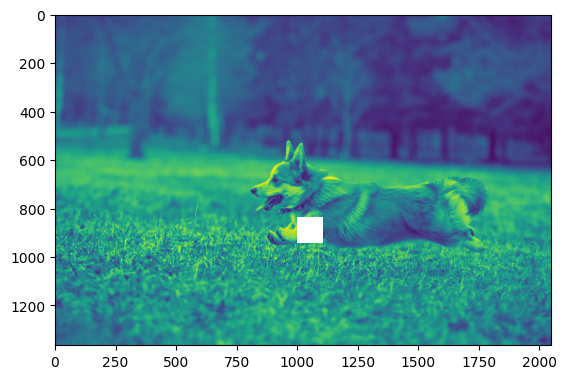

In [44]:
masked_img = mask_image(crop, 0)
masked_img[1].sum()
plt.imshow(masked_img[0])


In [45]:
W, H, loss = factorize(masked_img[0], 100, device=device)

z = torch.mm(W, H).cpu().detach().numpy()

In [46]:
W.shape, H.shape, crop.shape

(torch.Size([1365, 100]), torch.Size([100, 2048]), torch.Size([1365, 2048]))

torch.Size([1365, 2048])

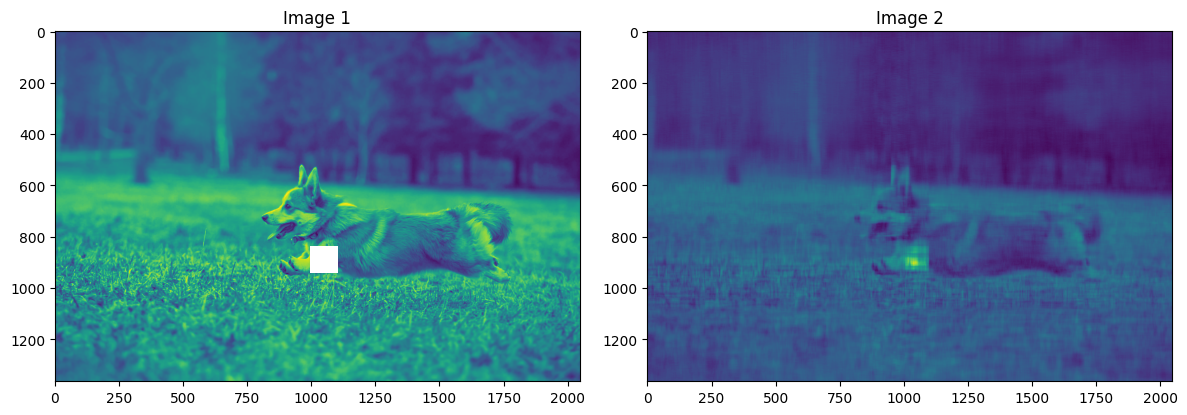

In [47]:
# Create two figures
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first figure
axs[0].imshow(crop.cpu())
axs[0].set_title('Image 1')

# Plot the second figure
axs[1].imshow(z)
axs[1].set_title('Image 2')

# Adjust spacing between subplots
plt.tight_layout()

crop.shape

In [48]:
def calculate_rmse(true_image, predicted_image):
    mask = ~torch.isnan(true_image)  # Create a mask to exclude NaN values
    true_image = true_image[mask]
    predicted_image = predicted_image[mask]
    mse = torch.mean((true_image - predicted_image) ** 2)
    return torch.sqrt(mse)

def calculate_psnr(true_image, predicted_image):
    mask = ~torch.isnan(true_image)  # Create a mask to exclude NaN values
    true_image = true_image[mask]
    predicted_image = predicted_image[mask]
    mse = torch.mean((true_image - predicted_image) ** 2)
    if mse == 0:  # MSE is zero means no noise is present in the signal.
                  # Therefore PSNR has no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr

In [49]:
rmse = calculate_rmse(crop.cpu(), z)
psnr = calculate_psnr(crop.cpu(), z)

print(f'RMSE: {rmse}')
print(f'PSNR: {psnr}')

RMSE: 0.04824863374233246
PSNR: 74.46110534667969


RMSE: 0.079387366771698
PSNR: 70.13577270507812


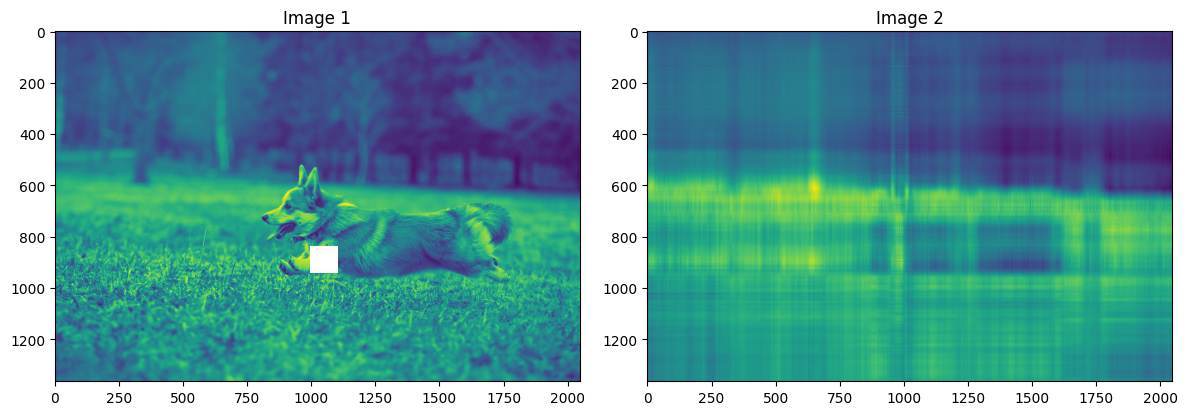

In [50]:
W, H, loss = factorize(masked_img[0], 5, device=device)

z = torch.mm(W, H).cpu().detach().numpy()

W.shape, H.shape, crop.shape

# Create two figures
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first figure
axs[0].imshow(crop.cpu())
axs[0].set_title('Image 1')

# Plot the second figure
axs[1].imshow(z)
axs[1].set_title('Image 2')

# Adjust spacing between subplots
plt.tight_layout()

crop.shape

def calculate_rmse(true_image, predicted_image):
    mask = ~torch.isnan(true_image)  # Create a mask to exclude NaN values
    true_image = true_image[mask]
    predicted_image = predicted_image[mask]
    mse = torch.mean((true_image - predicted_image) ** 2)
    return torch.sqrt(mse)

def calculate_psnr(true_image, predicted_image):
    mask = ~torch.isnan(true_image)  # Create a mask to exclude NaN values
    true_image = true_image[mask]
    predicted_image = predicted_image[mask]
    mse = torch.mean((true_image - predicted_image) ** 2)
    if mse == 0:  # MSE is zero means no noise is present in the signal.
                  # Therefore PSNR has no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr

rmse = calculate_rmse(crop.cpu(), z)
psnr = calculate_psnr(crop.cpu(), z)

print(f'RMSE: {rmse}')
print(f'PSNR: {psnr}')

RMSE: 0.08060550689697266
PSNR: 70.00350952148438


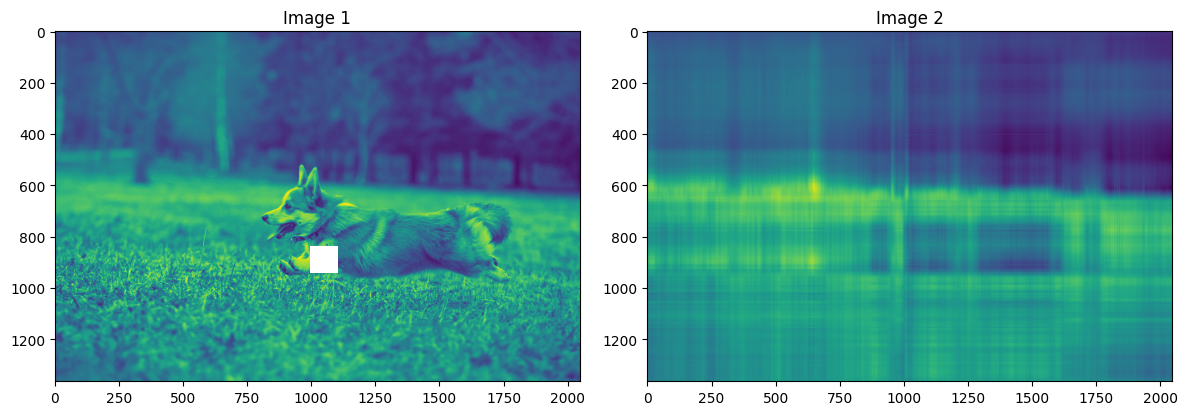

In [52]:
W, H, loss = factorize(masked_img[0], 5, device=device)

z = torch.mm(W, H).cpu().detach().numpy()

W.shape, H.shape, crop.shape

# Create two figures
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first figure
axs[0].imshow(crop.cpu())
axs[0].set_title('Image 1')

# Plot the second figure
axs[1].imshow(z)
axs[1].set_title('Image 2')

# Adjust spacing between subplots
plt.tight_layout()

crop.shape

def calculate_rmse(true_image, predicted_image):
    mask = ~torch.isnan(true_image)  # Create a mask to exclude NaN values
    true_image = true_image[mask]
    predicted_image = predicted_image[mask]
    mse = torch.mean((true_image - predicted_image) ** 2)
    return torch.sqrt(mse)

def calculate_psnr(true_image, predicted_image):
    mask = ~torch.isnan(true_image)  # Create a mask to exclude NaN values
    true_image = true_image[mask]
    predicted_image = predicted_image[mask]
    mse = torch.mean((true_image - predicted_image) ** 2)
    if mse == 0:  # MSE is zero means no noise is present in the signal.
                  # Therefore PSNR has no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr

rmse = calculate_rmse(crop.cpu(), z)
psnr = calculate_psnr(crop.cpu(), z)

print(f'RMSE: {rmse}')
print(f'PSNR: {psnr}')

RMSE: 0.07282610982656479
PSNR: 70.88506317138672


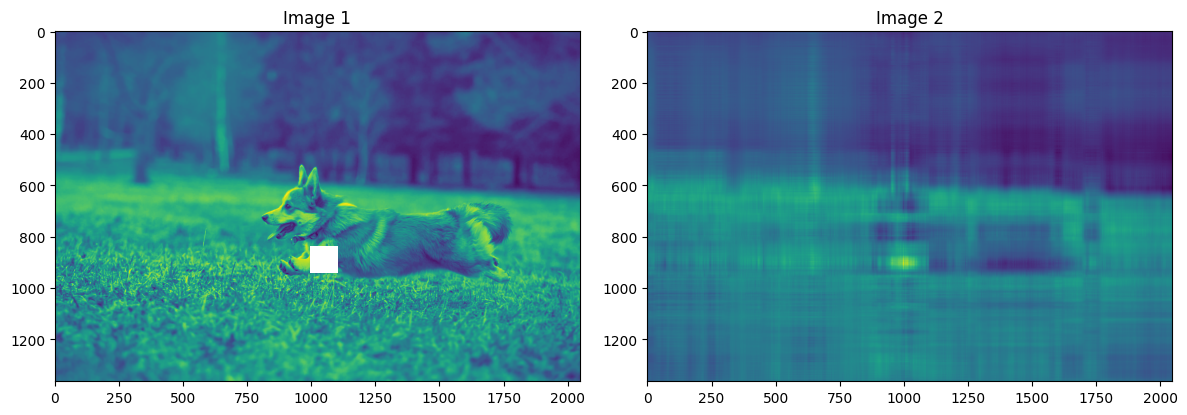

In [51]:
W, H, loss = factorize(masked_img[0], 10, device=device)

z = torch.mm(W, H).cpu().detach().numpy()

W.shape, H.shape, crop.shape

# Create two figures
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first figure
axs[0].imshow(crop.cpu())
axs[0].set_title('Image 1')

# Plot the second figure
axs[1].imshow(z)
axs[1].set_title('Image 2')

# Adjust spacing between subplots
plt.tight_layout()

crop.shape

def calculate_rmse(true_image, predicted_image):
    mask = ~torch.isnan(true_image)  # Create a mask to exclude NaN values
    true_image = true_image[mask]
    predicted_image = predicted_image[mask]
    mse = torch.mean((true_image - predicted_image) ** 2)
    return torch.sqrt(mse)

def calculate_psnr(true_image, predicted_image):
    mask = ~torch.isnan(true_image)  # Create a mask to exclude NaN values
    true_image = true_image[mask]
    predicted_image = predicted_image[mask]
    mse = torch.mean((true_image - predicted_image) ** 2)
    if mse == 0:  # MSE is zero means no noise is present in the signal.
                  # Therefore PSNR has no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr

rmse = calculate_rmse(crop.cpu(), z)
psnr = calculate_psnr(crop.cpu(), z)

print(f'RMSE: {rmse}')
print(f'PSNR: {psnr}')

RMSE: 0.06568636745214462
PSNR: 71.78129577636719


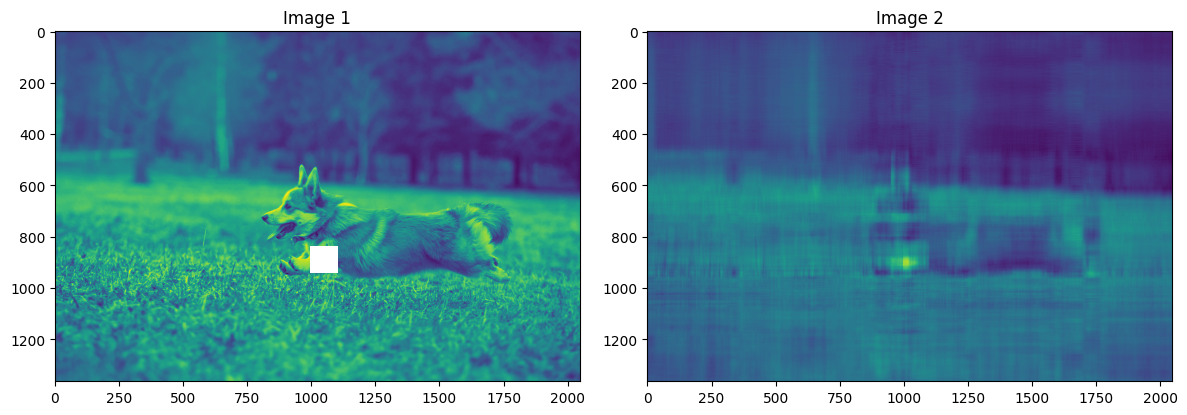

In [53]:
W, H, loss = factorize(masked_img[0], 25, device=device)

z = torch.mm(W, H).cpu().detach().numpy()

W.shape, H.shape, crop.shape

# Create two figures
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first figure
axs[0].imshow(crop.cpu())
axs[0].set_title('Image 1')

# Plot the second figure
axs[1].imshow(z)
axs[1].set_title('Image 2')

# Adjust spacing between subplots
plt.tight_layout()

crop.shape

def calculate_rmse(true_image, predicted_image):
    mask = ~torch.isnan(true_image)  # Create a mask to exclude NaN values
    true_image = true_image[mask]
    predicted_image = predicted_image[mask]
    mse = torch.mean((true_image - predicted_image) ** 2)
    return torch.sqrt(mse)

def calculate_psnr(true_image, predicted_image):
    mask = ~torch.isnan(true_image)  # Create a mask to exclude NaN values
    true_image = true_image[mask]
    predicted_image = predicted_image[mask]
    mse = torch.mean((true_image - predicted_image) ** 2)
    if mse == 0:  # MSE is zero means no noise is present in the signal.
                  # Therefore PSNR has no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr

rmse = calculate_rmse(crop.cpu(), z)
psnr = calculate_psnr(crop.cpu(), z)

print(f'RMSE: {rmse}')
print(f'PSNR: {psnr}')

RMSE: 0.056839704513549805
PSNR: 73.03776550292969


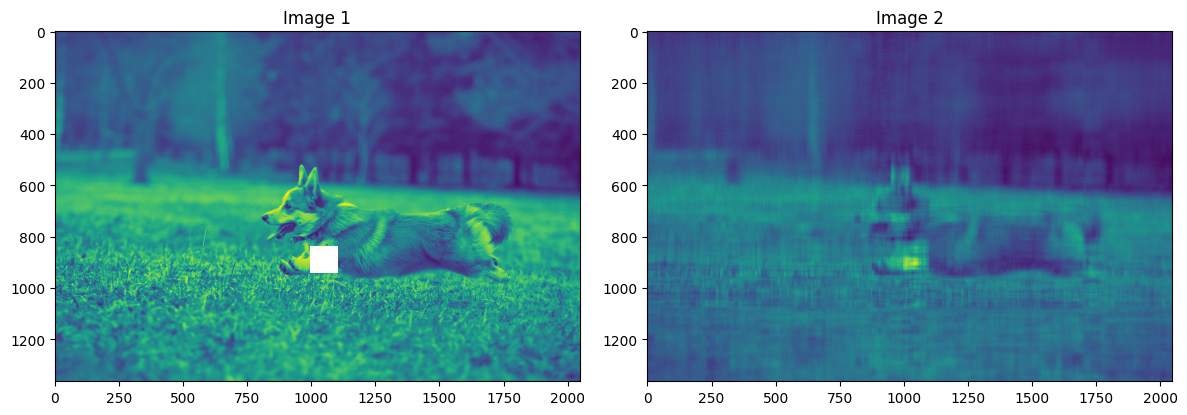

In [54]:
W, H, loss = factorize(masked_img[0], 50, device=device)

z = torch.mm(W, H).cpu().detach().numpy()

W.shape, H.shape, crop.shape

# Create two figures
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first figure
axs[0].imshow(crop.cpu())
axs[0].set_title('Image 1')

# Plot the second figure
axs[1].imshow(z)
axs[1].set_title('Image 2')

# Adjust spacing between subplots
plt.tight_layout()

crop.shape

def calculate_rmse(true_image, predicted_image):
    mask = ~torch.isnan(true_image)  # Create a mask to exclude NaN values
    true_image = true_image[mask]
    predicted_image = predicted_image[mask]
    mse = torch.mean((true_image - predicted_image) ** 2)
    return torch.sqrt(mse)

def calculate_psnr(true_image, predicted_image):
    mask = ~torch.isnan(true_image)  # Create a mask to exclude NaN values
    true_image = true_image[mask]
    predicted_image = predicted_image[mask]
    mse = torch.mean((true_image - predicted_image) ** 2)
    if mse == 0:  # MSE is zero means no noise is present in the signal.
                  # Therefore PSNR has no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr

rmse = calculate_rmse(crop.cpu(), z)
psnr = calculate_psnr(crop.cpu(), z)

print(f'RMSE: {rmse}')
print(f'PSNR: {psnr}')